# Report 3: Autoencoders

## Prithvi Poddar 17191

In this reort, we'll be developing Sparse autoencoder

## Sparse Autoencoder

### This autoencoder structure has been inspired by the note of Andrew NG on sparse autoencoders. We'll use the parameters mentioned in the notes itself

In [1]:
!pip3 install torch torchvision

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5))])

In [4]:
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [40]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 32, shuffle=False, num_workers=0)

We start off by defining our autoencoder structure. It will have 5 linear enoding layers and 5 linear decoding layers as can be seen below

In [6]:
class SparseAutoencoder(nn.Module):
    
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        
        #encoder
        self.en1 = nn.Linear(784, 256)
        self.en2 = nn.Linear(256, 128)
        self.en3 = nn.Linear(128, 64)
        self.en4 = nn.Linear(64, 32)
        self.en5 = nn.Linear(32, 16)

        #decoder
        self.de1 = nn.Linear(16, 32)
        self.de2 = nn.Linear(32, 64)
        self.de3 = nn.Linear(64, 128)
        self.de4 = nn.Linear(128, 256)
        self.de5 = nn.Linear(256, 784)

    def forward(self, x):
        #encoding
        x = F.relu(self.en1(x))
        x = F.relu(self.en2(x))
        x = F.relu(self.en3(x))
        x = F.relu(self.en4(x))
        x = F.relu(self.en5(x))

        #decoding
        x = F.relu(self.de1(x))
        x = F.relu(self.de2(x))
        x = F.relu(self.de3(x))
        x = F.relu(self.de4(x))
        x = F.relu(self.de5(x))

        return x

In [7]:
model = SparseAutoencoder().to(device)

Nex we extract the layers in the autoencoder individually so that we can use them to calculate the sparse loss by passing the imput images separately through all the layers

In [8]:
model_children = list(model.children())

Defining the KL divergence and Sparse Loss

In [9]:
def kl_div(rho, rho_hat):
  rho_hat = torch.mean(torch.sigmoid(rho_hat), 1) #sigmoid to squash the output between 0-1 to get probability distribution
  rho = torch.tensor([rho] * len(rho_hat)).to(device) # converting rho into a tensor of same size as rho_hat, for further calculations
  return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))

def sparse_loss(rho, images):
  values = images
  loss = 0
  for i in range(len(model_children)):
    values = model_children[i](values) #computing the activation after passing through the layer i of the model
    loss+=kl_div(rho, values)
  return loss

Finally we define the functin to train our model:

In [10]:
def train(model, epochs, learning_rate, RHO, BETA):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  training_losses = []
  test_losses = []

  for e in range(epochs):
    training_loss = 0.0
    test_loss = 0.0
    for inputs, labels in training_loader:
      inputs = inputs.view(inputs.shape[0], -1)
      inputs = inputs.to(device)
      outputs = model.forward(inputs)
      mse_loss = criterion(outputs, inputs)
      sparsity = sparse_loss(RHO, inputs)
      loss = mse_loss + BETA*sparsity
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_loss+=loss.item()

    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_inputs = val_inputs.view(val_inputs.shape[0], -1)
          val_outputs = model.forward(val_inputs)
          val_mse_loss = criterion(val_outputs, val_inputs)
          val_sparsity = sparse_loss(RHO, val_inputs)
          val_loss = val_mse_loss + BETA*val_sparsity
          test_loss += val_loss.item()

      epoch_loss = training_loss/len(training_loader)
      training_losses.append(epoch_loss)
      val_epoch_loss = test_loss/len(validation_loader)
      test_losses.append(val_epoch_loss)
      print('epoch :', (e+1))
      print('training loss: {:.4f} '.format(epoch_loss))
      print('validation loss: {:.4f} '.format(val_epoch_loss))

  return training_losses, test_losses


In [11]:
training_losses, test_losses = train(model, 100, 0.0001, 0.05, 0.001)

epoch : 1
training loss: 0.9419 
validation loss: 0.9367 
epoch : 2
training loss: 0.9363 
validation loss: 0.9367 
epoch : 3
training loss: 0.9359 
validation loss: 0.9341 
epoch : 4
training loss: 0.9323 
validation loss: 0.9275 
epoch : 5
training loss: 0.9268 
validation loss: 0.9254 
epoch : 6
training loss: 0.9247 
validation loss: 0.9229 
epoch : 7
training loss: 0.9223 
validation loss: 0.9198 
epoch : 8
training loss: 0.9195 
validation loss: 0.9178 
epoch : 9
training loss: 0.9170 
validation loss: 0.9152 
epoch : 10
training loss: 0.9154 
validation loss: 0.9138 
epoch : 11
training loss: 0.9143 
validation loss: 0.9127 
epoch : 12
training loss: 0.9129 
validation loss: 0.9109 
epoch : 13
training loss: 0.9106 
validation loss: 0.9079 
epoch : 14
training loss: 0.9080 
validation loss: 0.9058 
epoch : 15
training loss: 0.9063 
validation loss: 0.9044 
epoch : 16
training loss: 0.9050 
validation loss: 0.9033 
epoch : 17
training loss: 0.9039 
validation loss: 0.9021 
epoch 

In [12]:
def plot_loss(training_losses, testing_losses):
  plt.plot(training_losses, label='training loss')
  plt.plot(testing_losses, label='testing loss')
  plt.legend()

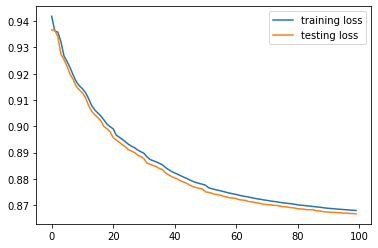

In [13]:
plot_loss(training_losses, test_losses)

### Now let's see how well this autoencoder regenerates the images in the MNIST validation dataset

We'll input 20 images from the validation set and see the outputs

In [14]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [15]:
def output_convert(image):
  img = image.view(28, 28)
  img = img.cpu().clone().detach().numpy()
  return img

In [16]:
data = iter(validation_loader)
images, labels = data.next()

#### The input images

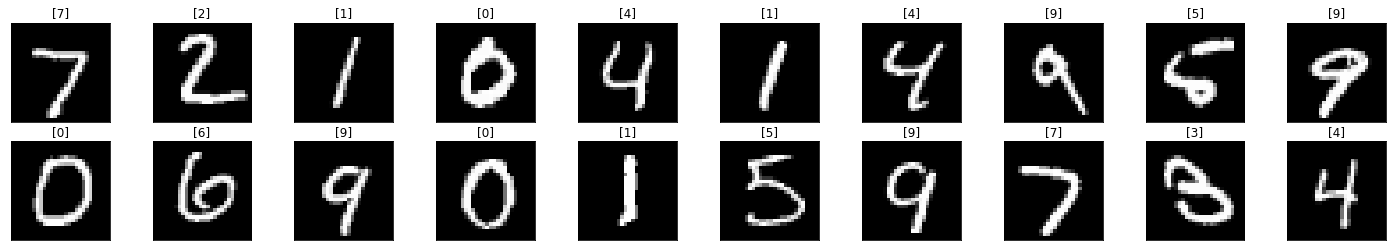

In [17]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [18]:
imgs = images.to(device)
imgs = imgs.view(imgs.shape[0], -1)
reconstructed = model.forward(imgs)

#### The output images

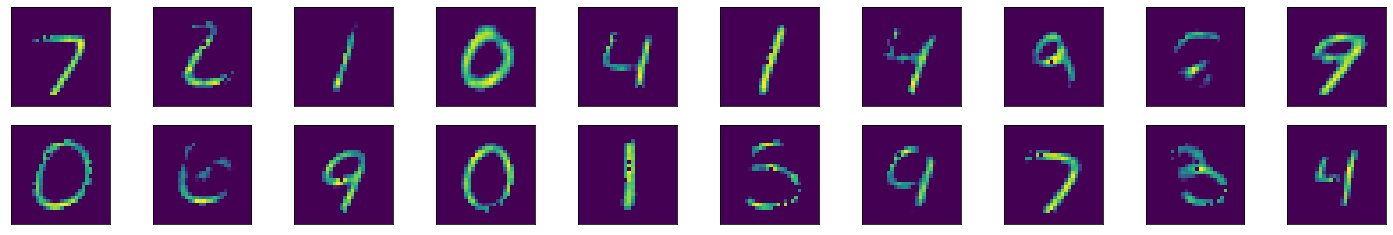

In [19]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(output_convert(reconstructed[idx]))